In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cargo el dataset
csv_path = 'data/Mall_Customers.csv'  
df = pd.read_csv(csv_path)
df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df['Gender'].nunique()

2

In [7]:
gender_counts = df['Gender'].value_counts()

# Crear lista de colores en el mismo orden que los índices
color_map = {"Male": "#1f77b4", "Female": "#ff7f0e"}
colors = [color_map[gender] for gender in gender_counts.index]


##  Visualización

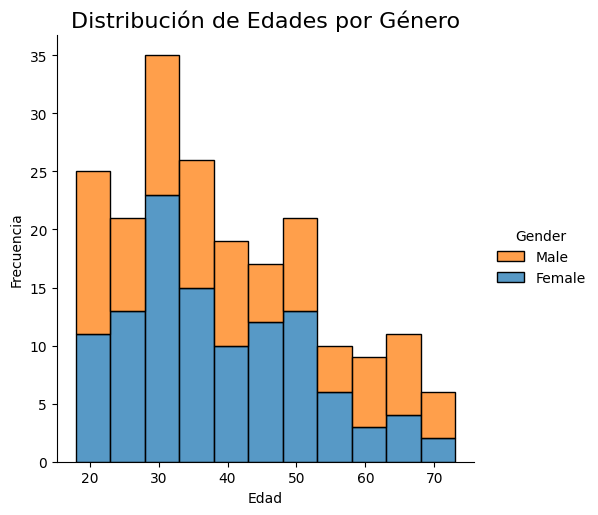

In [8]:
sns.displot(df, x="Age",binwidth=5, hue="Gender",palette = colors, multiple="stack")

plt.title("Distribución de Edades por Género", fontsize=16)
plt.xlabel("Edad", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)
plt.show()

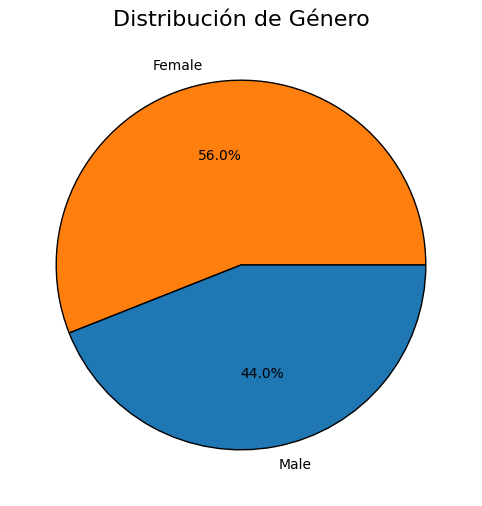

In [9]:
#Cuenta la cantidad de ocurrencias de cada valor único en la columna Gender
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=colors,wedgeprops={'edgecolor': 'black', 'linewidth': 1.0})
plt.title("Distribución de Género", fontsize=16)
plt.show()

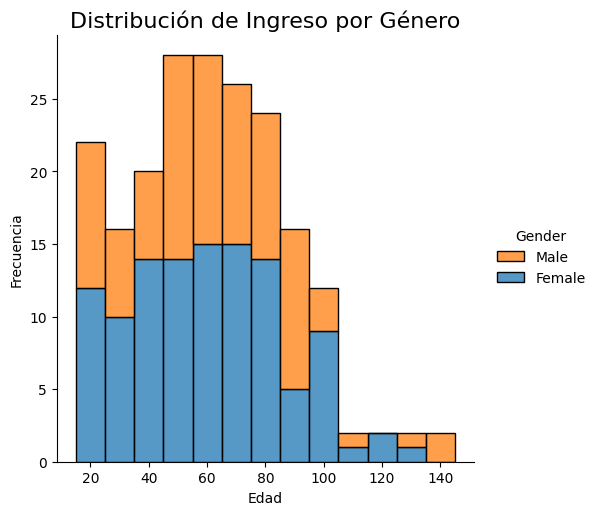

In [10]:
sns.displot(df, x="Annual Income (k$)",binwidth=10, hue="Gender",palette = colors, multiple="stack")

plt.title("Distribución de Ingreso por Género", fontsize=16)
plt.xlabel("Edad", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)
plt.show()

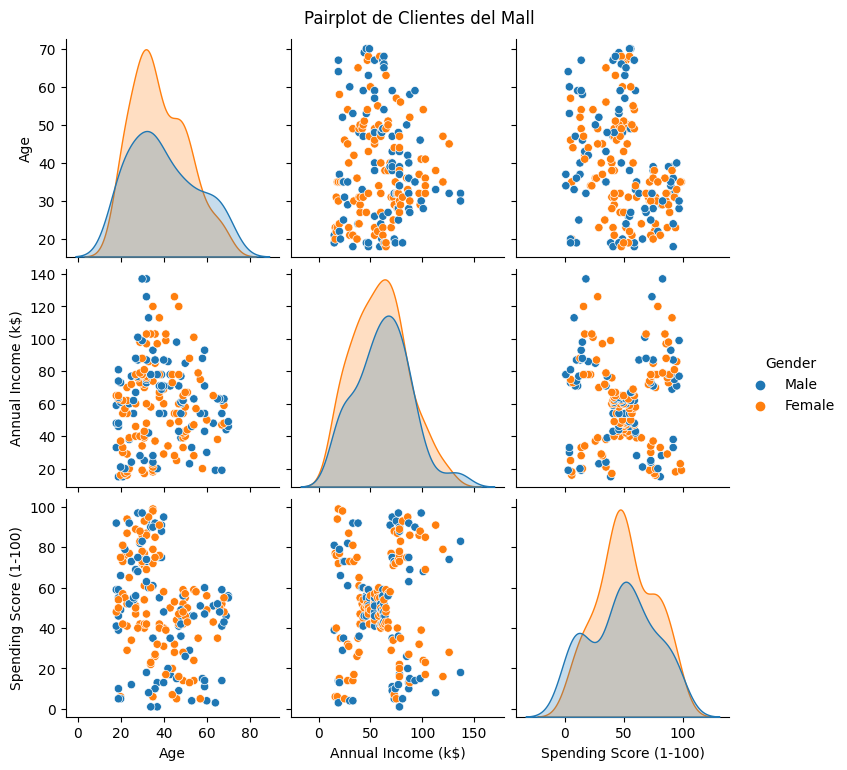

In [11]:
sns.pairplot(df.drop(columns=["CustomerID"]), hue="Gender")

# Mostrar el gráfico
plt.suptitle("Pairplot de Clientes del Mall", y=1.02)
plt.show()

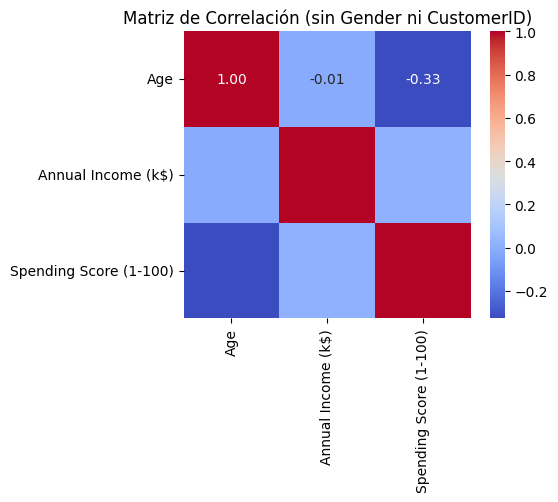

In [12]:
filtered_df = df.drop(columns=["CustomerID", "Gender"])

# Calcular la matriz de correlación solo con variables numéricas relevantes
corr_matrix_filtered = filtered_df.corr()

# Graficar la matriz de correlación limpia
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_filtered, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación (sin Gender ni CustomerID)")
plt.tight_layout()
plt.show()


### Resumen: 
1. Distribución por Género
La muestra tiene una distribución relativamente equilibrada entre hombres y mujeres. Esto permite hacer comparaciones válidas entre géneros sin sesgo de representación.
2. Edad
Hay una amplia variedad de edades entre los clientes. Se observa que las personas con menos de 50 años tienen un mayor gasto
3. Ingreso Anual vs Spending Score
No se detecta una correlación clara entre ingreso anual y nivel de gasto.
Esto refuerza la idea de que el ingreso no es el único factor que determina el comportamiento de compra.

# K-MEANS

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from tabulate import tabulate

In [14]:
clust_df = df.copy()
clust_df['Gender'] = [1 if i == "Female" else 0 for i in clust_df.Gender]
clust_df['Gasto_Relativo'] = clust_df['Spending Score (1-100)'] / clust_df['Annual Income (k$)']

clust_df = clust_df.drop(columns=["CustomerID", 'Gender'])

# Normalizar columnas numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clust_df)

Es importante normalizar porque si las variables tienen escalas diferentes (por ejemplo, ingreso en miles y edad en décadas), las de mayor escala dominan el análisis y distorsionan los resultados.



In [15]:
# Metodo del Elbow para determinar el número óptimo de clusters
k_means = []
for clust in range(1, 16):
    km = KMeans(n_clusters=clust, init='k-means++', random_state=42, n_init=10)
    km.fit(X_scaled)
    k_means.append(pd.Series({'Clusters': clust, 'Inertia': km.inertia_, 'model': km}))


plot_km = pd.concat(k_means, axis=1).T[['Clusters', 'Inertia']].set_index('Clusters')




# Lista de inercias desde el loop que ya hiciste
inertias = plot_km['Inertia'].values
k_range = list(plot_km.index)

kneedle = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
optimal_k = kneedle.knee

print(f"El número óptimo de clusters es: {optimal_k}")

El número óptimo de clusters es: 5


In [ ]:
# Gráfico de la curva de codo con línea dinámica en el óptimo k
fig = px.line(plot_km, x=plot_km.index, y='Inertia', markers=True,
              title="K-Means Clustering Elbow Curve (Normalizado)")
fig.update_traces(line_color='#518C89')

# Línea y anotación usando el optimal_k calculado por KneeLocator
fig.add_vline(x=optimal_k, line_width=3, line_dash="dash", line_color="darkgrey")
fig.add_annotation(
    x=optimal_k,
    y=plot_km.loc[optimal_k, 'Inertia'],
    text=f"Optimal Number of Clusters (k={optimal_k})",
    showarrow=True,
    arrowhead=2,
    ax=40, ay=-40,
    bgcolor='white',
    font=dict(size=12)
)

fig.update_layout(width=700, height=400)
fig.show()

In [ ]:
# modelo K-means con el número óptimo de clusters

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
clust_df['Cluster'] = kmeans.fit_predict(X_scaled)


clust_df['Cluster'] = clust_df['Cluster'].astype(str)

fig = px.scatter(
    clust_df,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Set2,  # Paleta de colores únicos
    title="Clusters de Clientes por Ingreso y Gasto"
)

fig.update_traces(marker=dict(size=10, opacity=0.8))
fig.update_layout(
    width=800,
    height=600,
    xaxis_title="Ingreso Anual (k$)",
    yaxis_title="Spending Score",
    legend_title="Cluster"
)
fig.show()

# 8. Estadísticas descriptivas por cluster en formato tabla
cluster_stats = clust_df.groupby('Cluster').agg({
    'Annual Income (k$)': ['mean', 'min', 'max', 'count'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Gasto_Relativo': ['mean', 'min', 'max']
}).round(2)

# Reinicia el índice para que 'Cluster' sea una columna
cluster_stats_reset = cluster_stats.reset_index()

print("\nEstadísticas por Cluster:")
print(tabulate(cluster_stats_reset, headers='keys', tablefmt='fancy_grid', showindex=False))


Estadísticas por Cluster:
╒═══════════════════╤══════════════════════════════════╤═════════════════════════════════╤═════════════════════════════════╤═══════════════════════════════════╤══════════════════════════════════════╤═════════════════════════════════════╤═════════════════════════════════════╤══════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│   ('Cluster', '') │   ('Annual Income (k$)', 'mean') │   ('Annual Income (k$)', 'min') │   ('Annual Income (k$)', 'max') │   ('Annual Income (k$)', 'count') │   ('Spending Score (1-100)', 'mean') │   ('Spending Score (1-100)', 'min') │   ('Spending Score (1-100)', 'max') │   ('Gasto_Relativo', 'mean') │   ('Gasto_Relativo', 'min') │   ('Gasto_Relativo', 'max') │
╞═══════════════════╪══════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪═══════════════════════════════════╪══════════════════════════════════════╪═════════════════════════════════════╪══

In [ ]:
## Validación del modelo
# Calcula el silhouette score para el clustering final
sil_score = silhouette_score(X_scaled, clust_df['Cluster'].astype(int))
print(f"Silhouette Score para k={optimal_k}: {sil_score:.3f}")

Silhouette Score para k=5: 0.410


# Conclusiones
K-Means permitió identificar 5 grupos de clientes con perfiles bien diferenciados según su ingreso y gasto.
El grupo más atractivo para la empresa es el Cluster 1 (alto ingreso y alto gasto).
El Cluster 3 representa una oportunidad: son clientes con alto ingreso pero bajo gasto, ideales para campañas que incentiven el consumo.
Los Clusters 0 y 4 agrupan a la mayoría de los clientes promedio, que también pueden ser objetivo de estrategias de fidelización o crecimiento.